## Libraries and Utilities

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re
import string
import torch
from collections import Counter
import xgboost as xgb
import plotnine
from plotnine import *
import shap

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_svmlight_files
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score 
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from torchsampler import ImbalancedDatasetSampler
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBRFRegressor
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.externals import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

# visualization modules
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts.basic_charts import pie
import missingno as msno

pd.set_option('display.max_columns',None)

## Read

In [4]:
df_origin = pd.read_csv('./../data0/data_z.csv')

df = df_origin.replace(['Benign/Likely_benign', 'Pathogenic/Likely_pathogenic'], ['Likely_benign', 'Likely_pathogenic']) 

df.drop(df[(df['CLNSIG'] != 'Benign') & (df['CLNSIG'] != 'Pathogenic') & (df['CLNSIG'] != 'Likely_benign') & (df['CLNSIG'] != 'Likely_pathogenic')].index, inplace=True)

df.reset_index(inplace=True)
df.drop(['index', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

## Sort & Fill

### 1

In [5]:
con_split = df['Consequence'].apply(lambda x: x if pd.isna(x) else x.split('&'))
mlb = MultiLabelBinarizer()
con_df = pd.DataFrame(mlb.fit_transform(con_split), columns=mlb.classes_)

In [6]:
def region_gen(x):
    if x['intergenic_variant'] == 1:
        return 1
    elif x['downstream_gene_variant'] == 1:
        return 2
    elif x['upstream_gene_variant'] == 1:
        return 3
    else:
        return 0

def region_utr(x):
    if x['5_prime_UTR_variant'] == 1:
        return 1
    elif x['3_prime_UTR_variant'] == 1:
        return 2
    else:
        return 0

def region_in(x):
    if x['intron_variant'] == 1:
        return 1
    else:
        return 0

# ex_con_df = con_df[['synonymous_variant', 'missense_variant', 'inframe_insertion', 'inframe_deletion', 'stop_gained', 'frameshift_variant', 'coding_sequence_variant', 'stop_lost', 'stop_retained_variant', 'start_lost', 'stop_retained_variant']]
# pca = PCA(n_components=10)
# principalComponents = pca.fit_transform(con_df)
# principalDf = pd.DataFrame(data=principalComponents)
# principalComponents

def region_ex(x):
    if x['missense_variant'] == 1:
        return 2
    elif x['synonymous_variant'] == 1:
        return 1
    else:
        return 0

# def region_ex(x):
#     if x['synonymous_variant'] == 1:
#         return 1
#     elif x['missense_variant'] == 1:
#         return 2
#     elif x['inframe_insertion'] == 1:
#         return 3
#     elif x['inframe_deletion'] == 1:
#         return 4
#     elif x['inframe_insertion'] == 1:
#         return 3
#     elif x['inframe_insertion'] == 1:
#         return 3
#     elif x['inframe_insertion'] == 1:
#         return 3
#     elif x['inframe_insertion'] == 1:
#         return 3
#     elif x['inframe_insertion'] == 1:
#         return 3
#     else:
#         return 0

def region_splice(x):
    if x['splice_acceptor_variant'] == 1:
        return 1
    elif x['splice_donor_variant'] == 1:
        return 2
    elif x['splice_region_variant'] == 1:
        return 3
    else:
        return 0


con_df['itergenic'] = con_df.apply(lambda x: region_gen(x), axis=1)
con_df['utr'] = con_df.apply(lambda x: region_utr(x), axis=1)
con_df['in'] = con_df.apply(lambda x: region_in(x), axis=1)
# con_df['ex']
con_df['splice'] = con_df.apply(lambda x: region_splice(x), axis=1)


In [7]:
df_copy = df.merge(con_df, left_on=df.index, right_on=con_df.index)
df_copy.drop('key_0', axis=1, inplace=True)
df_copy

,POS,ID,CLNSIG,Consequence,IMPACT,Feature,BIOTYPE,EXON,INTRON,SIFT,PolyPhen,MAX_AF,ada_score,rf_score,BLOSUM62,CADD_phred,CADD_raw,CADD_raw_rankscore,DANN_rankscore,DANN_score,Eigen-PC-raw,Eigen-raw,FATHMM_pred,GERP++_NR,GERP++_RS,LRT_pred,M-CAP_pred,MetaLR_pred,MetaSVM_pred,MutPred_rankscore,MutPred_score,MutationAssessor_pred,MutationTaster_pred,PROVEAN_pred,Polyphen2_HDIV_pred,Polyphen2_HVAR_pred,REVEL_rankscore,REVEL_score,SIFT_pred,SiPhy_29way_logOdds,SiPhy_29way_logOdds_rankscore,VEST3_rankscore,VEST3_score,phastCons100way_vertebrate,phastCons20way_mammalian,phyloP100way_vertebrate,phyloP20way_mammalian,gnomadWES_AF_POPMAX,gnomadWGS_AF_POPMAX,predict,3_prime_UTR_variant,5_prime_UTR_variant,coding_sequence_variant,downstream_gene_variant,frameshift_variant,inframe_deletion,inframe_insertion,intergenic_variant,intron_variant,missense_variant,protein_altering_variant,splice_acceptor_variant,splice_donor_variant,splice_region_variant,start_lost,start_retained_variant,stop_gained,stop_lost,stop_retained_variant,synonymous_variant,transcript_ablation,upstream_gene_variant,itergenic,utr,in,splice
0,865628,789256,Likely_benign,missense_variant,MODERATE,NM_152486.2,protein_coding,3/14,NaN,deleterious_low_confidence(0.01),benign(0.426),0.007525,NaN,NaN,NaN,22.0,2.938829,0.41362,0.42713,0.985760,-0.364107,-0.463727,NaN,4.13,2.22,N,NaN,T,T,NaN,NaN,M,N,D&D&D&.&.&.&.&.&.&.&.,B,B,0.25503,0.086,D&D&D&.&.&.&.&.&.&.&.,8.7244,0.33437,0.22976,0.164&0.16&0.188&0.115&0.188,1.0,0.187,2.486,0.862,5.25404e-03,3.93491e-03,2.239702,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,874778,769497,Benign,inframe_deletion,MODERATE,NM_152486.2,protein_coding,7/14,NaN,NaN,NaN,0.054040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.25005e-02,NaN,1.470504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,879375,950448,Pathogenic,stop_gained,HIGH,NM_152486.2,protein_coding,14/14,NaN,NaN,NaN,0.000174,NaN,NaN,NaN,29.8,6.442189,0.88892,0.17083,0.880060,-1.118530,-0.723670,NaN,3.78,-4.06,N,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN,NaN,NaN,NaN,NaN,15.4548,0.74924,NaN,NaN,0.0,0.002,-0.307,-0.588,1.78987e-04,NaN,2.118210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,879481,780745,Benign,missense_variant,MODERATE,NM_152486.2,protein_coding,14/14,NaN,deleterious(0),possibly_damaging(0.72),0.078730,NaN,NaN,NaN,23.0,3.443834,0.47190,0.54417,0.991843,0.037923,0.082109,NaN,5.05,4.13,D,NaN,T,T,NaN,NaN,M,D,D&.&.&.&.&.,P,B,0.29660,0.102,D&.&.&.&.&.,10.1963,0.42041,0.40539,0.264&0.231&0.344&0.218&0.21,1.0,0.662,2.811,0.138,7.85252e-02,7.68878e-02,2.239702,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,880944,730521,Benign,downstream_gene_variant,MODIFIER,NM_152486.2,protein_coding,NaN,NaN,NaN,NaN,0.009800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.66580e-03,5.04587e-03,1.311522,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394504,6931939,625467,Pathogenic,missense_variant&splice_region_variant,MODERATE,NM_134259.1,protein_coding,7/18,NaN,deleterious(0),possibly_damaging(0.812),0.005821,0.000562,0.006,-3.0,25.0,4.937533,0.66374,0.50185,0.990220,NaN,NaN,T&T&T,2.31,2.31,NaN,D,NaN,NaN,NaN,NaN,M,NaN,D,P,P,NaN,NaN,D,NaN,NaN,0.59868,0.566&0.566&0.566&0.566&0.566&0.566,1.0,0.966,6.040,0.785,NaN,NaN,2.527729,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
394505,6932191,719064,Benign,splice_donor_variant,HIGH,NM_134258.1,protein_coding,NaN,7/17,NaN,NaN,0.017080,0.999987,0.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### EXON

In [8]:
df_EXON = df_copy[df['EXON'].notna()]

In [9]:
pd.set_option('display.max_rows', 20)
df_EXON[df_EXON['missense_variant'] == 1].Consequence

0                               missense_variant
3                               missense_variant
8         missense_variant&splice_region_variant
11        missense_variant&splice_region_variant
19                              missense_variant
                           ...                  
394497                          missense_variant
394498                          missense_variant
394500                          missense_variant
394501                          missense_variant
394504    missense_variant&splice_region_variant
Name: Consequence, Length: 83006, dtype: object

In [10]:
df_EXON[df_EXON['missense_variant'] == 1].CLNSIG.value_counts()

Likely_benign        23419
Benign               20966
Pathogenic           19462
Likely_pathogenic    19159
Name: CLNSIG, dtype: int64

In [11]:
associate_dict = {
    'frameshift_variant': ['frameshift_variant', 'start_lost', 'stop_gained', 'stop_lost'],
    'inframe_deletion': ['inframe_deletion', 'start_lost', 'stop_gained', 'stop_lost'],
    'inframe_insertion': ['inframe_insertion', 'start_lost', 'stop_gained', 'stop_lost'],
    'downstream_gene_variant': ['downstream_gene_variant', 'upstream_gene_variant'],
    '3_prime_UTR_variant': ['3_prime_UTR_variant', '5_prime_UTR_variant'],
    'stop_gained': ['stop_gained'],
    'stop_lost': ['stop_lost'],
    'synonymous_variant': ['synonymous_variant'],
    'coding_sequence_variant': ['coding_sequence_variant'],
    'intergenic_variant': ['intergenic_variant'],
    'intron_variant': ['intron_variant'],
    'missense_variant': ['missense_variant'],
    'protein_altering_variant': ['protein_altering_variant'],
    'splice_acceptor_variant': ['splice_acceptor_variant'],
    'splice_donor_variant': ['splice_donor_variant'],
    'splice_region_variant': ['splice_region_variant'],
    'start_lost': ['start_lost'],
    'start_retained_variant': ['start_retained_variant'],
    'stop_retained_variant': ['stop_retained_variant'],
    'transcript_ablation': ['transcript_ablation'],
    'upstream_gene_variant': ['upstream_gene_variant']
}

In [12]:
# con_set =  set(df_EXON['Consequence'])
# index = 0

# for item in con_set:
#     t = df_EXON[df['Consequence'] == item].CADD_phred
#     print(item)
#     # print(index)
#     print(t.notna().sum())
#     print(t.notna().sum() / len(t))
#     print(t)
#     index += 1
#     # input()

In [13]:
# def fix(x, feature):
#     res = df_EXON_copy[(pd.notna(df_EXON_copy[feature])) & (df_EXON_copy['Consequence'] == x['Consequence'])]
#     return res[feature].mean()

# df_EXON_copy = df_EXON.copy()

# df_EXON['CADD_phred'] = df_EXON_copy.apply(lambda x: x if pd.notna(x['CADD_phred']) else fix(x, 'CADD_phred'), axis=1)



### INTRON

In [14]:
pd.set_option('display.max_rows', 20)
# df_INTRON['Consequence']

In [47]:
df_INTRON = df_copy[df_copy['INTRON'].notna()]

# df_INTRON['']
# ada_score
df_INTRON['ada_score'] = df_INTRON['ada_score'].fillna(df_INTRON.groupby('Consequence')['ada_score'].transform('mean'))

# rf_score
df_INTRON['rf_score'] = df_INTRON['rf_score'].fillna(df_INTRON.groupby('Consequence')['rf_score'].transform('mean'))

# AF
# def as_num(x):
#        y = '{:.5f}'.format(x)
#        return y
df_INTRON['gnomadWES_AF_POPMAX'] = df_INTRON['gnomadWES_AF_POPMAX'].apply(lambda x: 0 if (pd.isna(x)) or (x == '.') else float(x))
df_INTRON['AF'] = df_INTRON.apply(lambda x: np.mean([x['MAX_AF'], float(x['gnomadWES_AF_POPMAX'])]), axis=1)
df_INTRON['AF'].fillna(0)

le = LabelEncoder()
# IMPACT
df_INTRON['IMPACT'] = le.fit_transform(df_INTRON['IMPACT'])

# CLNSIG
df_INTRON['CLNSIG'] = le.fit_transform(df_INTRON['CLNSIG'])
df_INTRON['CLNSIG2'] = df_INTRON['CLNSIG'].apply(lambda x: 1 if x > 1 else 0)

in_cols = ['IMPACT',
       'AF', 'ada_score', 'rf_score',
       '3_prime_UTR_variant', '5_prime_UTR_variant', 'coding_sequence_variant',
       'intron_variant',
       'splice_acceptor_variant', 'splice_donor_variant',
       'splice_region_variant', 'splice'
       ]

inputs_in = df_INTRON[in_cols]
target_in = df_INTRON['CLNSIG2']

ros = RandomOverSampler(random_state=0)

X_in_train, X_in_test, y_in_train, y_in_test = train_test_split(inputs_in, target_in, test_size = 0.25, shuffle = True)

bst_in = XGBRFRegressor()

bst_in.fit(X_in_train, y_in_train)

res_in = pd.DataFrame(y_in_test)
res_in['pred'] = bst_in.predict(X_in_test)

<AxesSubplot:xlabel='pred', ylabel='Density'>

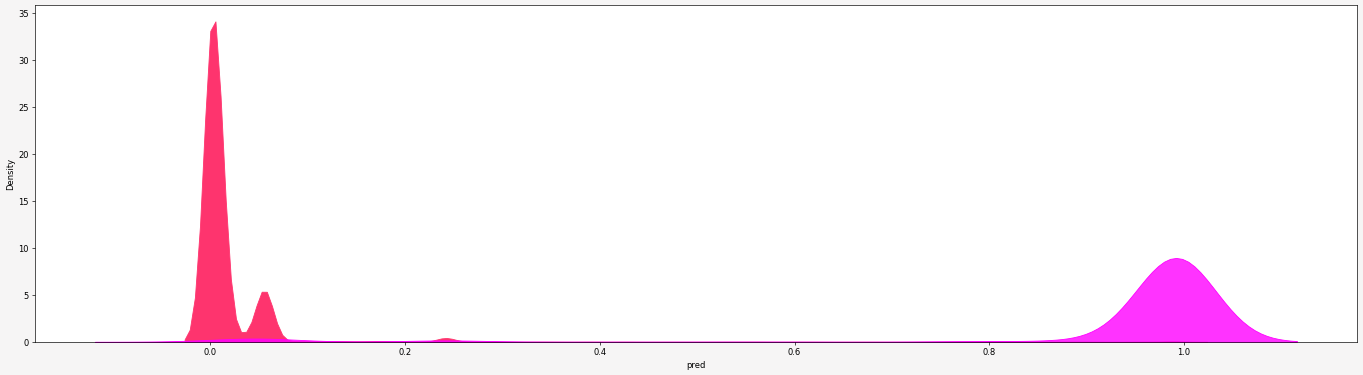

In [48]:
fig = plt.figure(figsize=(72, 52), dpi=60)

gs = fig.add_gridspec(20, 20)
# gs.update(wspace=1, hspace=0.05)
ax1 = fig.add_subplot(gs[1:4, 0:8])

fig.patch.set_facecolor('#f6f5f5')

sns.kdeplot(data=res_in[res_in['CLNSIG2'] == 0], x='pred', ax=ax1, shade=True, color='#fe346e', alpha=1)
sns.kdeplot(data=res_in[res_in['CLNSIG2'] == 1], x='pred', ax=ax1, shade=True, color='#FF00FF', alpha=0.8) 

In [49]:
res_in['pred_class'] = res_in['pred'].apply(lambda x: 1 if x > 0.5 else 0)

print(classification_report(res_in['CLNSIG2'], res_in['pred_class']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15621
           1       0.99      0.94      0.96      4233

    accuracy                           0.98     19854
   macro avg       0.98      0.97      0.98     19854
weighted avg       0.98      0.98      0.98     19854



In [57]:
confusion_matrix(res_in['CLNSIG2'], res_in['pred_class'])

array([[15561,    60],
       [  253,  3980]], dtype=int64)

[0.06273691 0.02162316 0.57237554 0.24294965 0.00126549 0.00102154
 0.0006237  0.0830753  0.00107533 0.00178819 0.00712149 0.0043437 ]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

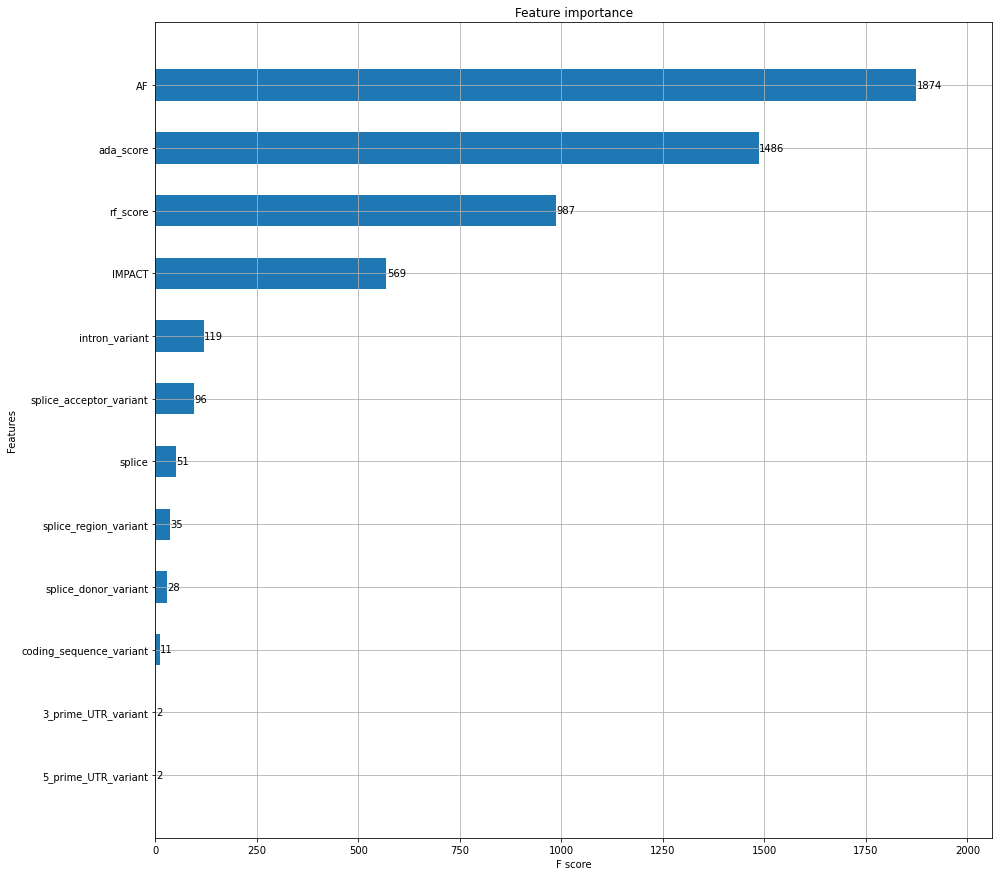

In [50]:
print(bst_in.feature_importances_)
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(bst_in, height=0.5, ax=ax)

In [51]:
joblib.dump(bst_in, 'bst_in_rf.pkl')

['bst_in_rf.pkl']

### splice

## Format & Label

In [52]:
def format(df):
    # Consequence
    con_split = df['Consequence'].apply(lambda x: x if pd.isna(x) else x.split('&'))
    mlb = MultiLabelBinarizer()
    con_df = pd.DataFrame(mlb.fit_transform(con_split), columns=mlb.classes_)

    # principalDf = pd.DataFrame
    
    # pca = PCA(n_components=12)
    # principalComponents = pca.fit_transform(con_df)
    # principalDf = pd.DataFrame(data=principalComponents)
    
    # df_new = df.merge(principalDf, left_on=df.index, right_on=principalDf.index)
    df_new = df.merge(con_df, left_on=df.index, right_on=con_df.index)

    # EXON
    df_new['EXON'] = df_new['EXON'].apply(lambda x: 0 if pd.isna(x) else 1)

    # INTRON
    df_new['INTRON'] = df_new['INTRON'].apply(lambda x: 0 if pd.isna(x) else 1)

    # SIFT
    df_new['SIFT'] = df_new['SIFT'].apply(lambda x: x if pd.isna(x) else re.sub(r"\(.*\)", "", x))

    # PolyPhen
    df_new['PolyPhen'] = df_new['PolyPhen'].apply(lambda x: x if pd.isna(x) else re.sub(r"\(.*\)", "", x))

    # FATHMM_pred
    df_new['FATHMM_pred'] = df_new['FATHMM_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # MutationTaster_pred D N A
    # df['MutationTaster_pred'] = df['MutationTaster_pred'].apply(lambda x: x if pd.isna(x) else x.count('D')/(x.count('D')+x.count('N')))
    df_new['MutationTaster_pred'] = df_new['MutationTaster_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # PROVEAN_pred
    df_new['PROVEAN_pred'] = df_new['PROVEAN_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # Polyphen2_HDIV_pred
    df_new['Polyphen2_HDIV_pred'] = df_new['Polyphen2_HDIV_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # Polyphen2_HVAR_pred
    df_new['Polyphen2_HVAR_pred'] = df_new['Polyphen2_HVAR_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # SIFT_pred
    df_new['SIFT_pred'] = df_new['SIFT_pred'].apply(lambda x: x if pd.isna(x) else max(string.ascii_uppercase, key=x.count))

    # VEST3_score
    df_new['VEST3_score'] = df_new['VEST3_score'].apply(lambda x: x if pd.isna(x) else np.mean(list(map(eval, x.split('&')))))
    
    # MAX_AF
    # df_new['MAX_AF'].fillna(0, inplace=True)
    
    return df_new

# df_format = format(df)



In [53]:
def label(df):    
    le = LabelEncoder()
    df_new = df.copy()
    df_new['SIFT'] = le.fit_transform(df['SIFT'])
    df_new['PolyPhen'] = le.fit_transform(df['PolyPhen'])
    df_new['FATHMM_pred'] = le.fit_transform(df['FATHMM_pred'])
    df_new['MutationTaster_pred'] = le.fit_transform(df['MutationTaster_pred'])
    df_new['PROVEAN_pred'] = le.fit_transform(df['PROVEAN_pred'])
    df_new['Polyphen2_HDIV_pred'] = le.fit_transform(df['Polyphen2_HDIV_pred'])
    df_new['Polyphen2_HVAR_pred'] = le.fit_transform(df['Polyphen2_HVAR_pred'])
    df_new['SIFT_pred'] = le.fit_transform(df['SIFT_pred'])
    df_new['IMPACT'] = le.fit_transform(df['IMPACT'])
    # df['LRT_pred'] = le.fit_transform(df['LRT_pred'])
    df_new['M-CAP_pred'] = le.fit_transform(df['M-CAP_pred'])
    df_new['MetaSVM_pred'] = le.fit_transform(df['MetaSVM_pred'])
    df_new['MutationAssessor_pred'] = le.fit_transform(df['MutationAssessor_pred'])
    if 'CLNSIG' in df.columns:
        df_new['CLNSIG'] = le.fit_transform(df['CLNSIG'])
    return df_new

## next

In [54]:
# set(df['Consequence'])

In [55]:
df_INTRON[df_INTRON['CLNSIG2'] == 1].AF

96        0.000010
311            NaN
616            NaN
624            NaN
695            NaN
            ...   
394368         NaN
394408         NaN
394418         NaN
394445         NaN
394461    0.000042
Name: AF, Length: 17007, dtype: float64

In [56]:
# pd.set_option('display.max_rows', None)
# df[(df['Consequence'].str.contains('incomplete_terminal_codon_variant'))]
# pd.set_option('display.max_rows', 20)
# len(df)
# print(df[df['Consequence'].str.contains('splice_acceptor_variant')].Consequence)
